## Analisis de datos sobre críticas de las pelicula: Past Lives

Tareas: 
* Almacenar 250 reseñas más relevantes de la película en IMDB en una base de datos. 
* Proponer 3 estrategias de marketing basadas en los datos obtenidos de esas reseñas para incrementar la popularidad de la peli. 
* Prepara una presentación ejecutiva con proceso de obtención, data analysis, limpieza, visualizaciones, estrategia de actuación. 

In [29]:
#Libraries
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords
from nltk import word_tokenize
from unidecode import unidecode
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from collections import Counter

import time
import re 
import nltk
import requests
import itertools

In [20]:
# * Archivos
# nltk.download('stopwords')
spanish_dict = 'diccionarios/spanish-wordlist.txt'
english_dict = 'diccionarios/english-wordlist.txt'

with open('diccionarios/english-wordlist.txt','r') as file:
    english_dict_words = set(file.read().splitlines())

with open('diccionarios/spanish-wordlist.txt','r') as file: 
    spanish_dict_words = set(file.read().splitlines())

In [21]:
def clean_text(text_input, language):
    # Check if the language is supported
    if language not in ['english', 'spanish']:
        raise ValueError('Error: Solo se puede seleccionar Español e Inglés.')

    # Escogemos el diccionario basado en la lengua
    dict_words = english_dict_words if language == 'english' else spanish_dict_words

    # 1. Convertimos el texto a minusculas
    pure_text = re.sub(r'[^\w\s]', '', text_input.lower())
    
    # 2. Quitamos las stop words.
    pure_text = ' '.join([word for word in pure_text.split() if word not in stopwords.words(language)])
    
    # 3. Filtrar palabras no encontradas en el diccionario. 
    filtered_words = [word for word in word_tokenize(pure_text) if word in dict_words]
    incorrect_words = [word for word in word_tokenize(pure_text) if word not in dict_words]
    
    # Opcional: Para manejar las palabras juntas es dificil separarlas.
    return filtered_words, incorrect_words


In [22]:
REVIEW_NUMBER = 250

def extract_imdb_reviews_first_page(imdb_id):
    url = f'https://www.imdb.com/title/{imdb_id}/reviews'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    reviews = []
    for item in soup.find_all('div', class_='review-container'):
        reviews.append(item.text.strip())
    
    return reviews

In [23]:
def extract_imdb_reviews_all(imdb_id):
    url = f'https://www.imdb.com/title/{imdb_id}/reviews'
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # Run in background
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(url)

    reviews = []

    try:
        while len(reviews) < REVIEW_NUMBER:
            # Parse the page source with BeautifulSoup
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            for item in soup.find_all('div', class_='text show-more__control'):
                reviews.append(item.text.strip())
                if len(reviews) >= REVIEW_NUMBER:
                    break

            # Attempt to click the "Load More" button to load more reviews
            try:
                load_more_button = driver.find_element(By.CLASS_NAME, 'ipl-load-more__button')
                driver.execute_script("arguments[0].click();", load_more_button)
                time.sleep(2)  # Wait for the page to load more content
            except (NoSuchElementException, ElementClickInterceptedException):
                break  # If no more "Load More" button is found or click fails, exit loop
    finally:
        driver.quit()  # Make sure to close the driver

    return reviews[:REVIEW_NUMBER]  # Return the list of reviews

In [24]:
def clean_reviews_english(review_list):
    cleaned_reviews = []
    errors = []

    for review in review_list:
        clean_review, error = clean_text(review, 'english')
        cleaned_reviews.append(clean_review)
        errors.append(error)
        print(clean_review)

    return cleaned_reviews, errors

In [25]:
# Replace 'tt0120338' with the actual IMDb ID of the movie/show you're interested in
all_past_lives_reviews_list = extract_imdb_reviews_all('tt13238346')

"""for review in all_past_lives_reviews_list: 
    print("\n --- \n")
    print(review)"""

'for review in all_past_lives_reviews_list: \n    print("\n --- \n")\n    print(review)'

In [27]:
all_past_lives_reviews_keywords, _ = clean_reviews_english(all_past_lives_reviews_list)
print(all_past_lives_reviews_keywords)
len(all_past_lives_reviews_keywords)

['past', 'lives', 'like', 'stephen', 'song', 'come', 'know', 'song', 'road', 'take', 'follies', 'different', 'doors', 'exist', 'along', 'path', 'life', 'get', 'enter', 'one', 'time', 'leaving', 'wonder', 'behind', 'doors', 'one', 'path', 'necessarily', 'better', 'worse', 'another', 'different', 'never', 'know', 'behind', 'doors', 'choose', 'anyway', 'time', 'eventually', 'smooth', 'regret', 'feel', 'choosing', 'instead', 'except', 'always', 'may', 'never', 'stop', 'completely', 'regretting', 'life', 'think', 'might', 'even', 'really', 'mind', 'life', 'movie', 'song', 'watching', 'beautifully', 'defined', 'female', 'character', 'convince', 'husband', 'life', 'wants', 'wish', 'shed', 'taken', 'chance', 'childhood', 'sweetheart', 'comes', 'back', 'life', 'years', 'apart', 'charts', 'chemistry', 'actors', 'play', 'sweethearts', 'adults', 'greta', 'lee', 'exceptional', 'lee', 'creates', 'fascinating', 'character', 'bit', 'cold', 'bit', 'distant', 'always', 'even', 'completely', 'likable', '

250

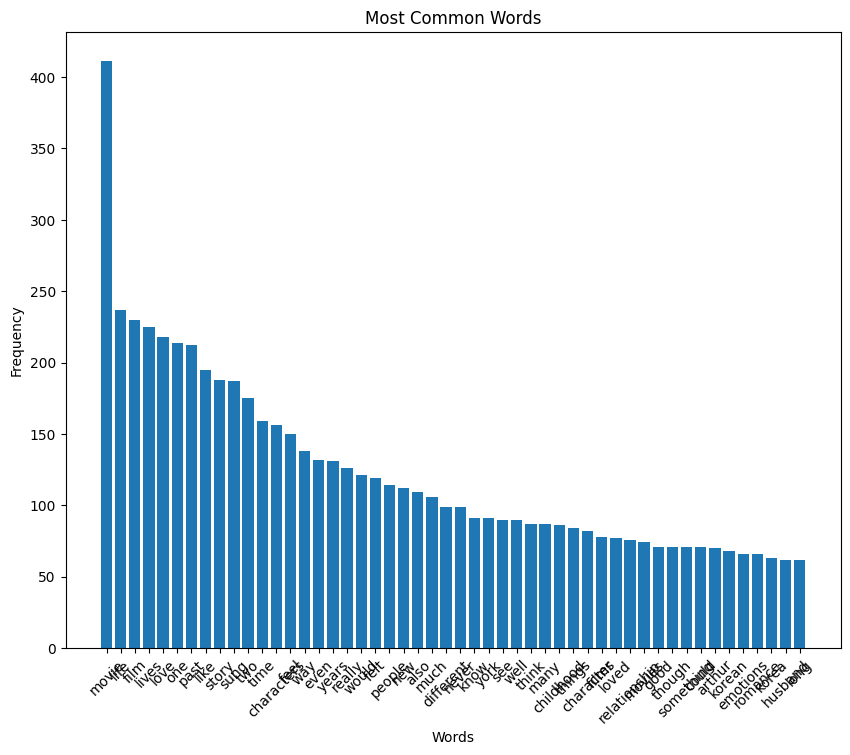

In [32]:
import matplotlib.pyplot as plt
# Flatten the list of lists
flattened_list = list(itertools.chain.from_iterable(all_past_lives_reviews_keywords))
# Count the words
word_counts = Counter(flattened_list)
# Get the most common words
most_common_words = word_counts.most_common()
# Unzip the words and their frequencies
words, frequencies = zip(*most_common_words[:50])

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words')
plt.xticks(rotation=45)  # Rotate the words on x-axis for better readability
plt.show()

### Planificación: 
* Nube de palabras -> Strength
* Distribución de las criticas para identificar en que país, la peli, para promocionar en las otras regiones. 
* 